# Assessment 02

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from enum import Enum

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Data Load and Check

In [4]:
def load_data_and_inspect(csv_path:str) -> pd.DataFrame:
	print(f"Loading data from ({csv_path})\n")

	df = pd.read_csv(csv_path, header=0, sep=';')
	
	# Check the shape of the dataset (number of rows and columns)
	print(f"-- Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
	
	# Get general info about the dataset, including data types and non-null counts
	print(f"\nDataset Info\n {df.info()}\n")
	
	# Check for missing values
	print(f"Missing values in dataset\n {df.isnull().sum()}\n")

	# Display the first 5 rows of the dataset
	print(f"Head data:\n{df.head()}\n")

	# Describe the numeric columns for basic statistics
	print(f"Descriptive Statistics\n{df.describe()}\n")

	return df

## Exploratory Data Analysis (EDA)

### Univariate Analysis - Categorical Varialbes
No categorical values found on this dataSet

In [5]:
def summary(df:pd.DataFrame):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summ['Missing#'] = df.isna().sum()
    summ['Missing%'] = (df.isna().sum())/len(df)
    summ['Dups'] = df.duplicated().sum()
    summ['Uniques'] = df.nunique().values
    summ['Count'] = df.count().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['Min'] = desc['min'].values
    summ['Max'] = desc['max'].values
    summ['Average'] = desc['mean'].values
    summ['Standard Deviation'] = desc['std'].values
    summ['First Value'] = df.loc[0].values
    summ['Second Value'] = df.loc[1].values
    summ['Third Value'] = df.loc[2].values

    display(summ)

### Univariate Variable Analysis - Numerical Variables

In [6]:
class DistributionType(Enum):
	CATEGORICAL = 1
	NUMERICAL = 2

In [7]:

def generate_distribution_plots(df:pd.DataFrame, plot_fn, distribution_type: DistributionType = DistributionType.CATEGORICAL, exclude_columns:list = [], ):
	print(f"{distribution_type.name} distribution")
	
	evaluation_columns = []

	match distribution_type:
		case DistributionType.CATEGORICAL:
			evaluation_columns = df.select_dtypes(include=['object', 'category']).columns

		case DistributionType.NUMERICAL:
			evaluation_columns = df.select_dtypes(include=['int64', 'float64']).columns
	
	df = df[evaluation_columns].copy()
	df.drop(exclude_columns, axis=1, inplace=True)

	plot_fn(df, distribution_type)

In [8]:
def plot_distribution(df:pd.DataFrame, distribution_type: DistributionType):
	# Set font dictionary for titles and labels
	font = {'family': 'serif',
					'color': 'darkred',
					'weight': 'normal',
					'size': 16,
					}

	# Create subplots 
	fig, axes = plt.subplots(nrows=(len(df.columns) + 1) // 2, ncols=2,figsize=(17,8))
	fig.subplots_adjust(hspace=0.7)

	match distribution_type:
		case DistributionType.CATEGORICAL:

			# Loop over each categorical feature and its respective subplot
			for i, (ax, feature) in enumerate(zip(axes.flatten(), df.columns)):
					sns.countplot(x=feature, data=df, ax=ax, palette="mako")  # Apply color palette here
					ax.set_title(f'Analysis of {feature}', fontdict=font)
					ax.set_ylabel('Count', fontdict=font)
					
					# Rotate x-axis labels diagonally
					ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
					
					# Place xlabel only on the diagonal
					if i % (2 + 1) == 0:  # Check if we are on the diagonal
							ax.set_xlabel(feature, fontdict=font)

			# Adjust layout to prevent overlap and display the plot
			plt.tight_layout()	

		case DistributionType.NUMERICAL:
			# Generate histplot
			for ax, feature in zip(axes.flatten(), df.columns):
				feature_mean = df[feature].mean()
				feature_median = df[feature].median()
				feature_mode = df[feature].mode().values[0]
				sns.histplot(df[feature],ax=ax, palette="mako")
				ax.set_title(f'Analysis of {feature}', fontdict=font)
				ax.axvline(feature_mean, color='r', linestyle='--', label="Mean")
				ax.axvline(feature_median, color='g', linestyle='--', label="Median")
				ax.axvline(feature_mode, color='b', linestyle='--', label="Mode")
				ax.legend()

	plt.show()


In [9]:
def normality_test_with_plots(df: pd.DataFrame):
    # Select numerical columns
    evaluation_columns = df.select_dtypes(include=['int64', 'float64']).columns

    # Loop through each numeric column
    for column in evaluation_columns:
        # Create subplots (1 row, 3 columns)
        _, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Plot Histogram and KDE
        sns.histplot(df[column], kde=True, color='blue', stat='density', bins=30, ax=axes[0])
        axes[0].set_title(f"Histogram and KDE of {column}", fontsize=16)
        axes[0].set_xlabel(column, fontsize=12)
        axes[0].set_ylabel("Density", fontsize=12)

        # Q-Q Plot
        stats.probplot(df[column], dist="norm", plot=axes[1])
        axes[1].set_title(f"Q-Q Plot of {column}", fontsize=16)

        # Boxplot
        sns.boxplot(x=df[column], color='orange', ax=axes[2])
        axes[2].set_title(f"Boxplot of {column}", fontsize=16)
        axes[2].set_xlabel(column, fontsize=12)

        # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.show()

## Plot the Target Variable


In [10]:
def plot_correlation_test(data:pd.DataFrame, heu:str):
	sns.pairplot(data, hue=heu)
	plt.show()


	evaluation_columns = data.select_dtypes(include=['int64', 'float64']).columns
	# Compute and visualize the correlation matrix
	plt.figure(figsize=(10, 6))
	sns.heatmap(data[evaluation_columns].corr('spearman'), annot=True, cmap='coolwarm', fmt='.2f')
	plt.title('Correlation Matrix')
	plt.show()

## Data Preparation

In [11]:
# Remove outliers using IQR method
def remove_outliers_iqr(df: pd.DataFrame, exclude_columns:list) -> pd.DataFrame:
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_columns = list(set(numerical_columns) - set(exclude_columns))
    
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

In [12]:
# Remove outliers using Z-score method
def remove_outliers_zscore(df: pd.DataFrame, exclude_columns:list) -> pd.DataFrame:
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_columns = list(set(numerical_columns) - set(exclude_columns))

    for column in numerical_columns:
        z_scores = np.abs(stats.zscore(df[column]))
        
        # Keep rows where z-score is less than 3
        df = df[z_scores < 3]
    
    return df

In [13]:
def remove_outliers_best_method(df: pd.DataFrame, exclude_columns:list) -> pd.DataFrame:
    # Save the original number of rows
    original_rows = len(df)

    # Apply the IQR method and measure how much data was removed
    df_iqr = remove_outliers_iqr(df.copy(), exclude_columns)
    iqr_removed = original_rows - len(df_iqr)

    # Apply the Z-score method and measure how much data was removed
    df_zscore = remove_outliers_zscore(df.copy(), exclude_columns)
    zscore_removed = original_rows - len(df_zscore)

    # Compare the number of rows removed and choose the method with the least removal
    if iqr_removed <= zscore_removed:
        print(f"IQR method removed {iqr_removed} rows, which is less than the Z-score method ({zscore_removed} rows).")
        return df_iqr
    else:
        print(f"Z-score method removed {zscore_removed} rows, which is less than the IQR method ({iqr_removed} rows).")
        return df_zscore


In [14]:
# Data Preparation
def data_preparation(data:pd.DataFrame, exclude_columns:list = [])->pd.DataFrame:
	# Handle missing values (if any)
	# Replace missing values with the median
	# data.fillna(data.median(), inplace=True)
	data.drop_duplicates(inplace=True)
	
	data = remove_outliers_best_method(data, exclude_columns)

	return data

In [15]:
def plot_histogram_before_after(df: pd.DataFrame, df_without_outliers: pd.DataFrame):
    # Get numerical columns before and after outlier removal
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    # numerical_columns_after = df_without_outliers.select_dtypes(include=['int64', 'float64']).columns

    # Create subplots
    _, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, 5 * len(numerical_columns)))

    for i, column in enumerate(numerical_columns):
        # Plot before removing outliers
        sns.histplot(df[column], kde=True, ax=axes[i, 0], color='orange', bins=30)
        axes[i, 0].set_title(f'Before Removing Outliers: {column}', fontsize=14)

        # Plot after removing outliers (corrected this part to reference the full column from df_without_outliers)
        sns.histplot(df_without_outliers[column], kde=True, ax=axes[i, 1], color='blue', bins=30)
        axes[i, 1].set_title(f'After Removing Outliers: {column}', fontsize=14)

    plt.tight_layout()
    plt.show()

### Training definition

In [16]:
def onehot_encoder(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    # Initialize OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    
    # Reshape the column to be a 2D array as expected by OneHotEncoder
    reshaped = df[column_name].values.reshape(-1, 1)
    
    # Apply OneHotEncoder
    encoded_array = onehot_encoder.fit_transform(reshaped)
    
    # Convert the encoded array back to a DataFrame with the appropriate column names
    encoded_df = pd.DataFrame(encoded_array, columns=onehot_encoder.categories_[0], index=df.index)
    
    # Drop the original column from the DataFrame and concatenate the encoded columns
    df_encoded = pd.concat([df.drop([column_name], axis=1), encoded_df], axis=1)
    
    return df_encoded

In [17]:
class TrainDefinitionData:
	def __init__(self):
		self.X_value = None
		self.Y_value = None

		self.X_train = None
		self.Y_train = None

		self.X_test = None
		self.Y_test = None

		self.X_train_scaled = None
		self.X_test_scaled = None

In [18]:
def train_definition(data:pd.DataFrame, target_var:str)-> TrainDefinitionData | MinMaxScaler:
	def_data :TrainDefinitionData = TrainDefinitionData()

	# Define features (X) and target (y)
	def_data.X_value = data.drop(columns=[target_var])
	def_data.Y_value = data[target_var]

	
	# Train-test split
	def_data.X_train, def_data.X_test, def_data.Y_train, def_data.Y_test = train_test_split(def_data.X_value, def_data.Y_value, test_size=0.2, random_state=42)

	# Feature scaling
	scaler = MinMaxScaler()
	def_data.X_train_scaled = scaler.fit_transform(def_data.X_train)
	def_data.X_test_scaled = scaler.transform(def_data.X_test)

	return def_data, scaler

### Classification process
### Decision Tree

In [19]:
# Modeling with Decision Tree
def modeling_decision_tree(def_data:TrainDefinitionData)-> DecisionTreeRegressor:
	print("\nModeling with Decision Tree:")
	dt_model = DecisionTreeRegressor(random_state=42)
	dt_model.fit(def_data.X_train_scaled, def_data.Y_train)
	y_pred_dt = dt_model.predict(def_data.X_test_scaled)

	# Evaluate Decision Tree
	mse_dt = mean_squared_error(def_data.Y_test, y_pred_dt)
	mae_dt = mean_absolute_error(def_data.Y_test, y_pred_dt)
	r2_dt = r2_score(def_data.Y_test, y_pred_dt)
	print(f"Decision Tree Metrics:\nMSE: {mse_dt}, MAE: {mae_dt}, R2 Score: {r2_dt}")
	print(f"Decision Tree - R2 Score: {r2_dt}")


In [20]:
# Hyperparameter Tuning for Decision Tree
def sleep_hyperparameter_tuning(def_data:TrainDefinitionData)->DecisionTreeRegressor:
	param_grid_dt = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
	grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=5, scoring='r2')
	grid_dt.fit(def_data.X_train_scaled, def_data.Y_train)
	best_dt_model = grid_dt.best_estimator_

	print(f"Best Parameters for Decision Tree: {grid_dt.best_params_}")
	y_pred_best_dt = best_dt_model.predict(def_data.X_test_scaled)
	r2_best_dt = r2_score(def_data.Y_test, y_pred_best_dt)
	print(f"R2 Score after tuning: {r2_best_dt}")

	return best_dt_model	

### Linear regression

In [21]:
# Modeling with Linear Regression
def modeling_linear_regression(def_data:TrainDefinitionData)-> LinearRegression:
	print("\nModeling with Linear Regression:")
	lr_model = LinearRegression()
	lr_model.fit(def_data.X_train_scaled, def_data.Y_train)
	y_pred_lr = lr_model.predict(def_data.X_test_scaled)

	# Evaluate Linear Regression
	mse_lr = mean_squared_error(def_data.Y_test, y_pred_lr)
	mae_lr = mean_absolute_error(def_data.Y_test, y_pred_lr)
	r2_lr = r2_score(def_data.Y_test, y_pred_lr)
	print(f"Linear Regression Metrics:\nMSE: {mse_lr}, MAE: {mae_lr}, R2 Score: {r2_lr}")
	print(f"Linear Regression - R2 Score: {r2_lr}")

	return lr_model

Loading data from (../data/learning/rental_in_lisbon/rental_lisbon.csv)

-- Dataset Shape: 1465 rows, 8 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       1465 non-null   object 
 1   price_€       1465 non-null   int64  
 2   typology      1465 non-null   object 
 3   area          1465 non-null   float64
 4   latitude      1465 non-null   int64  
 5   longitude     1465 non-null   int64  
 6   neighborhood  1465 non-null   object 
 7   room          1465 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 91.7+ KB

Dataset Info
 None

Missing values in dataset
 address         0
price_€         0
typology        0
area            0
latitude        0
longitude       0
neighborhood    0
room            0
dtype: int64

Head data:
                                        address  price_€ typology   are

,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,First Value,Second Value,Third Value
address,object,0,0.0,58,828,1465,NaN,NaN,NaN,NaN,"Praca da Alegria, Santo Antonio","Campo de Santana, Santa Marta, Santo Antonio","Praca de Camoes, Misericordia"
price_€,int64,0,0.0,58,212,1465,500.0,25000.0,2616.758362,1952.570453,2990,2010,3520
typology,object,0,0.0,58,11,1465,NaN,NaN,NaN,NaN,T2,T1,T2
area,float64,0,0.0,58,235,1465,1.046,668.0,111.817096,68.893721,82.0,60.0,105.0
latitude,int64,0,0.0,58,1127,1465,38774.0,38797543.0,35625991.898976,10002624.673245,38722836,38719455,38710898
longitude,int64,0,0.0,58,1136,1465,-9215478.0,-9129.0,-8070495.63413,2812020.986113,-9147145,-9144216,-9143774
neighborhood,object,0,0.0,58,24,1465,NaN,NaN,NaN,NaN,Santo Antonio,Santo Antonio,Misericordia
room,int64,0,0.0,58,11,1465,0.0,21.0,2.264164,1.346106,2,1,2


CATEGORICAL distribution


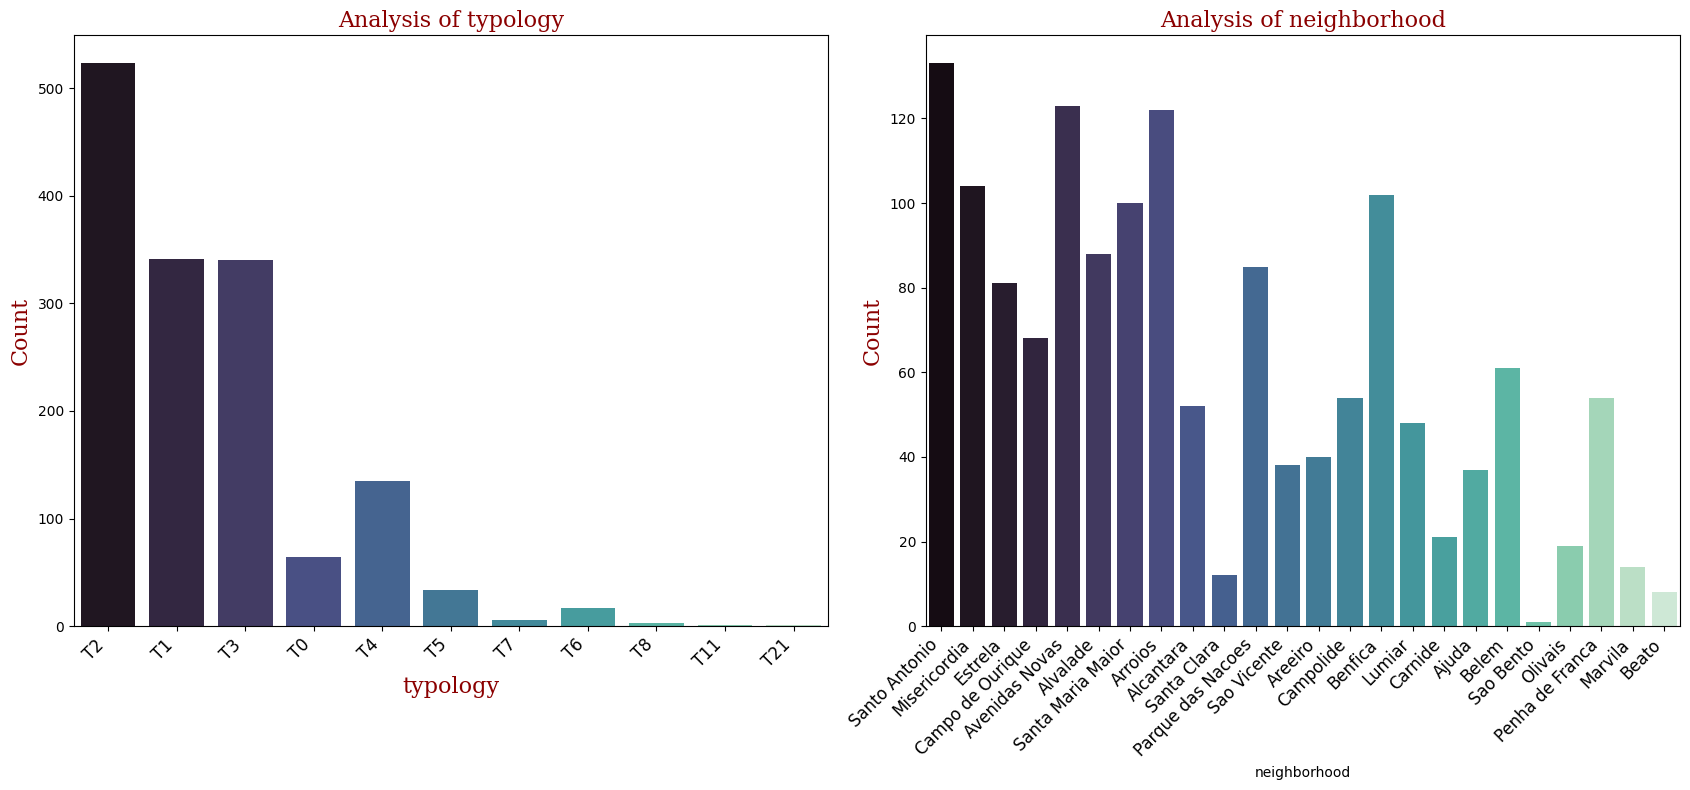

NUMERICAL distribution


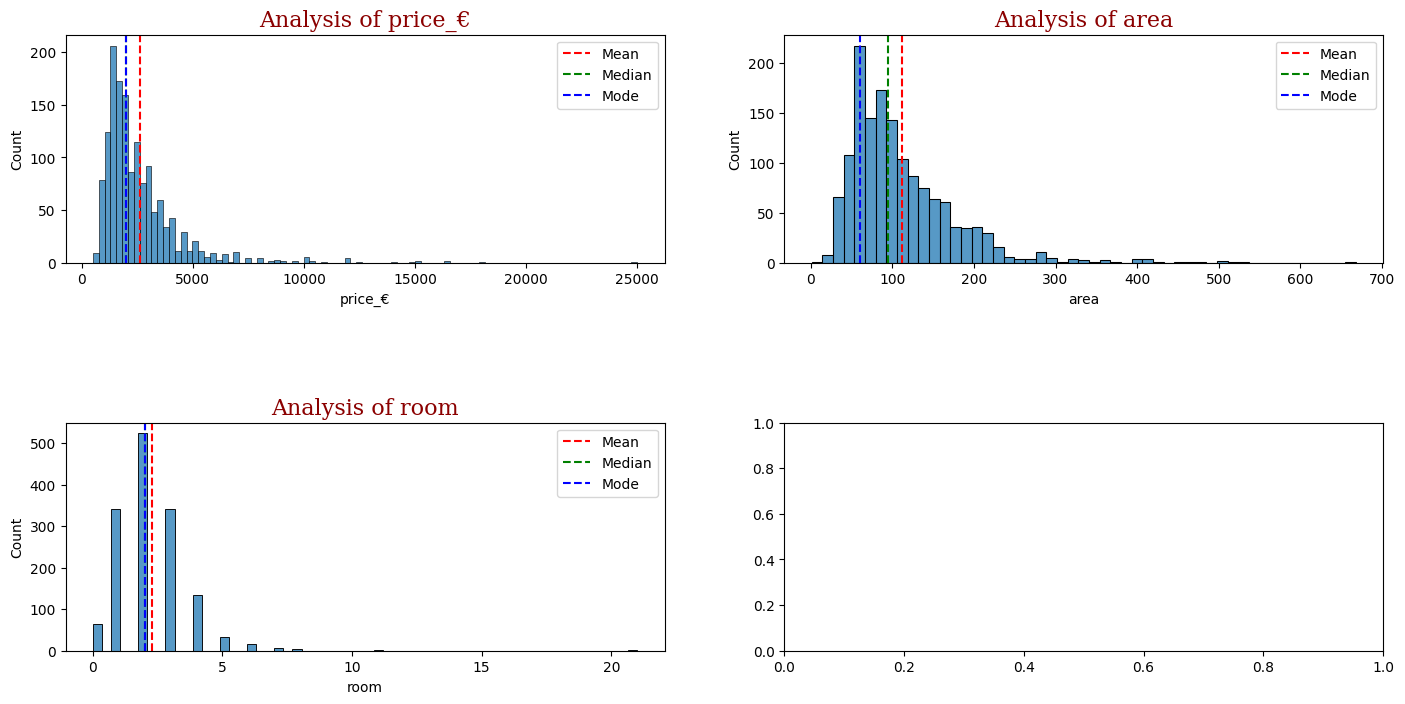

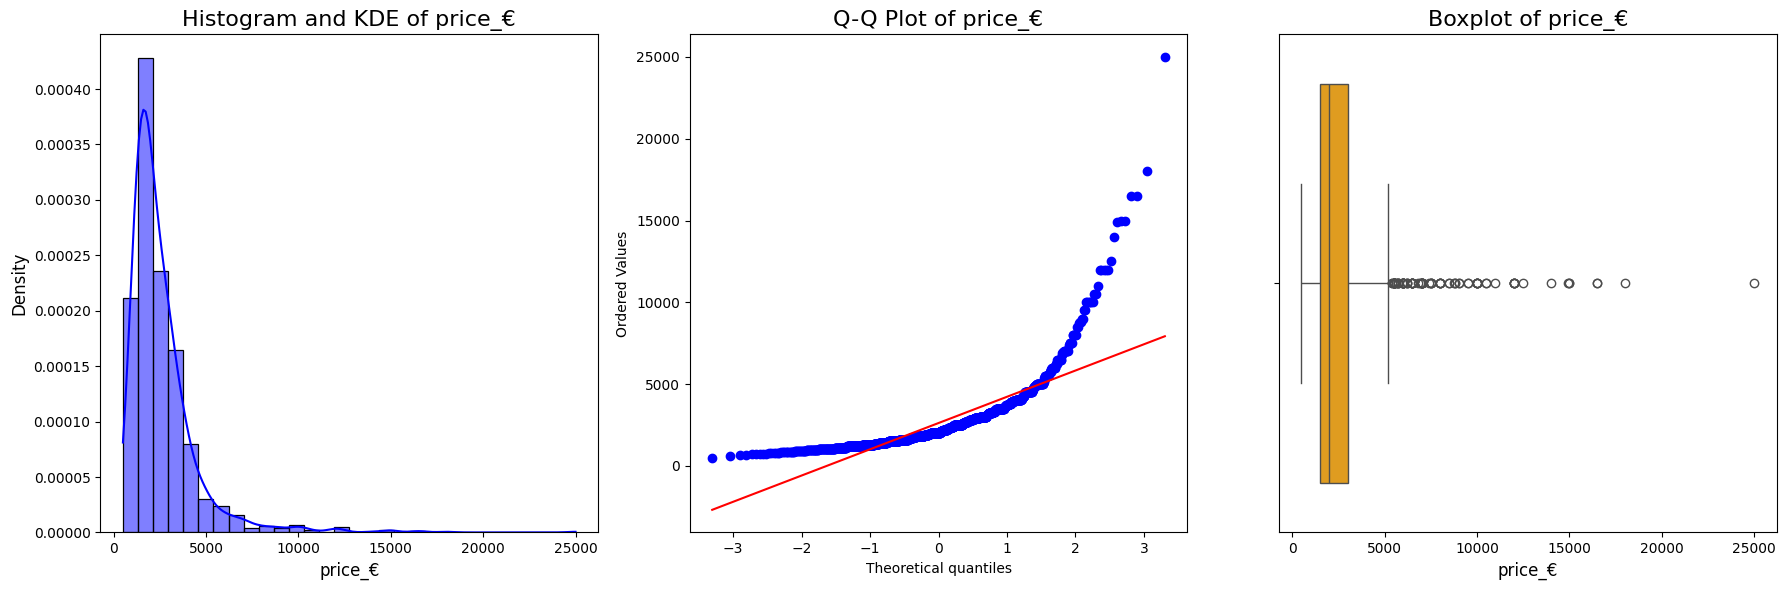

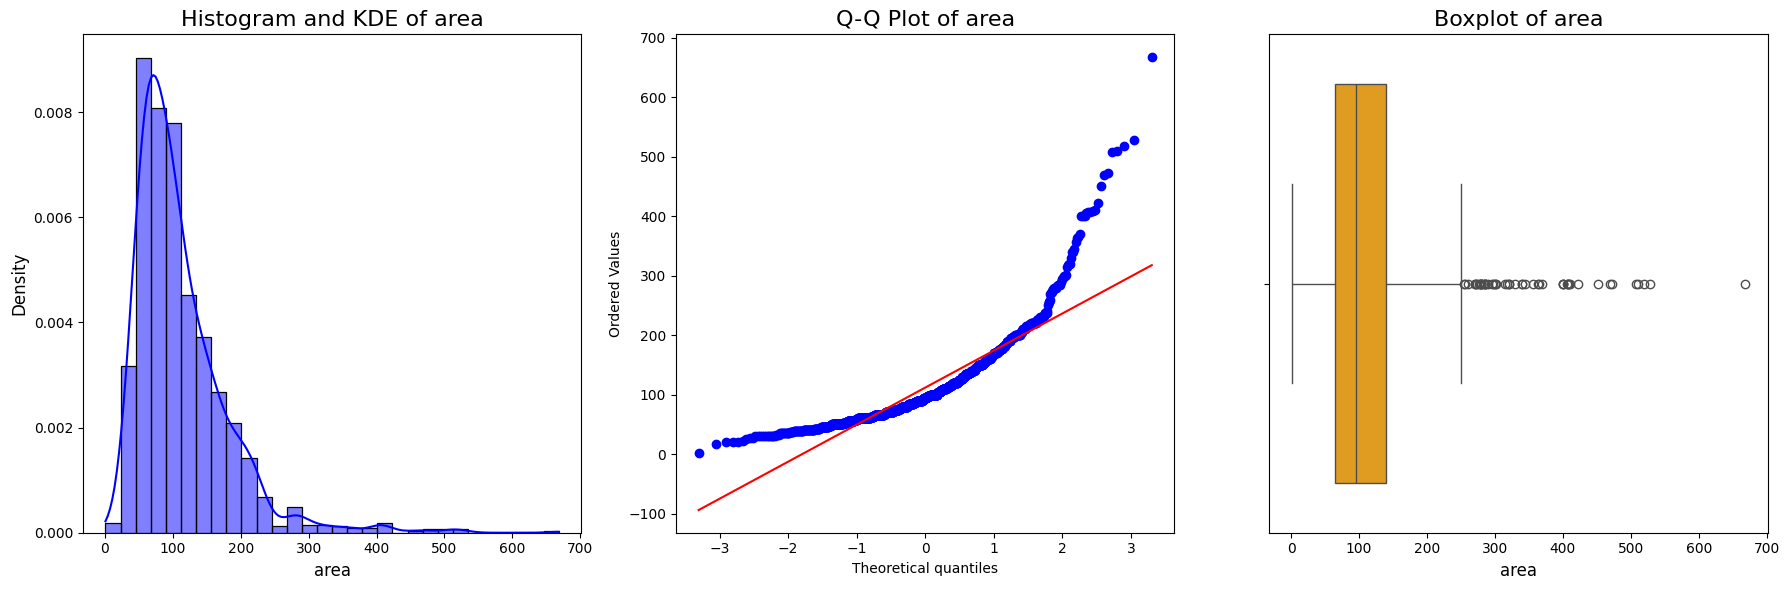

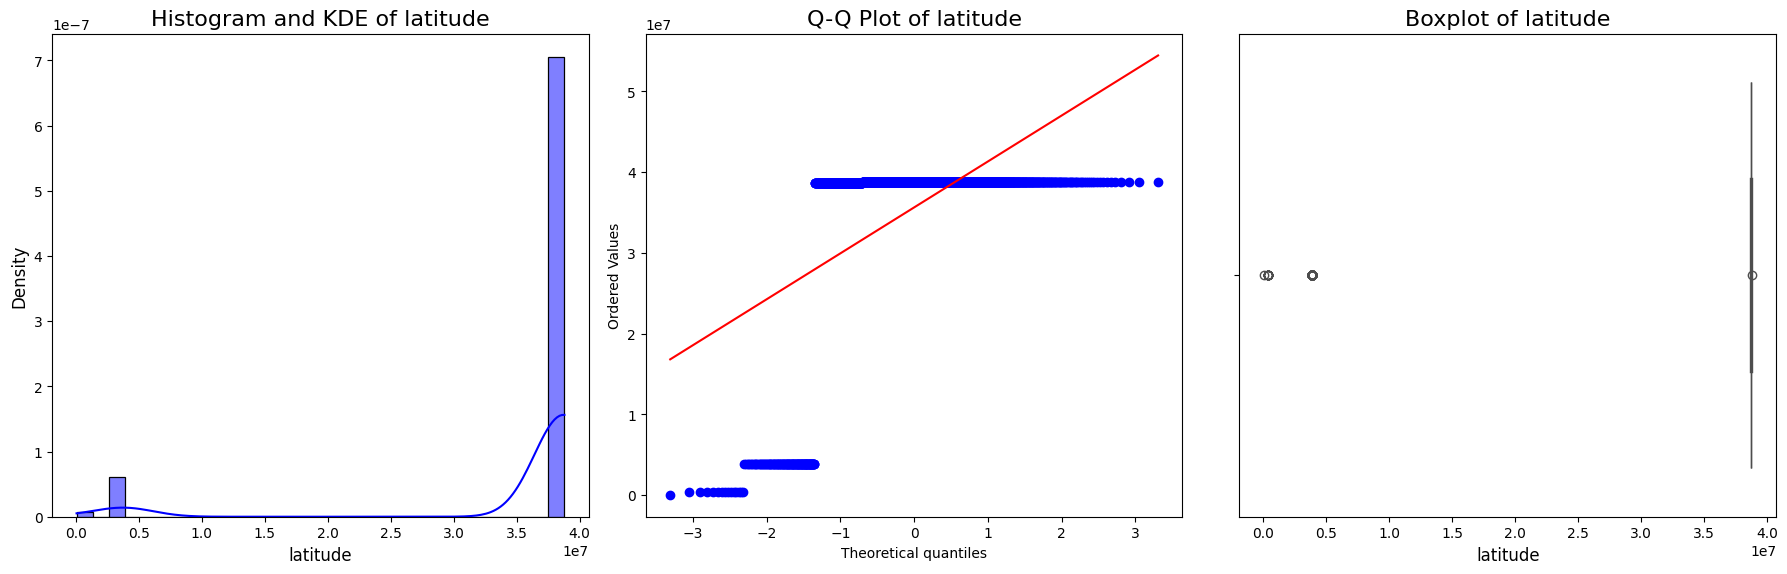

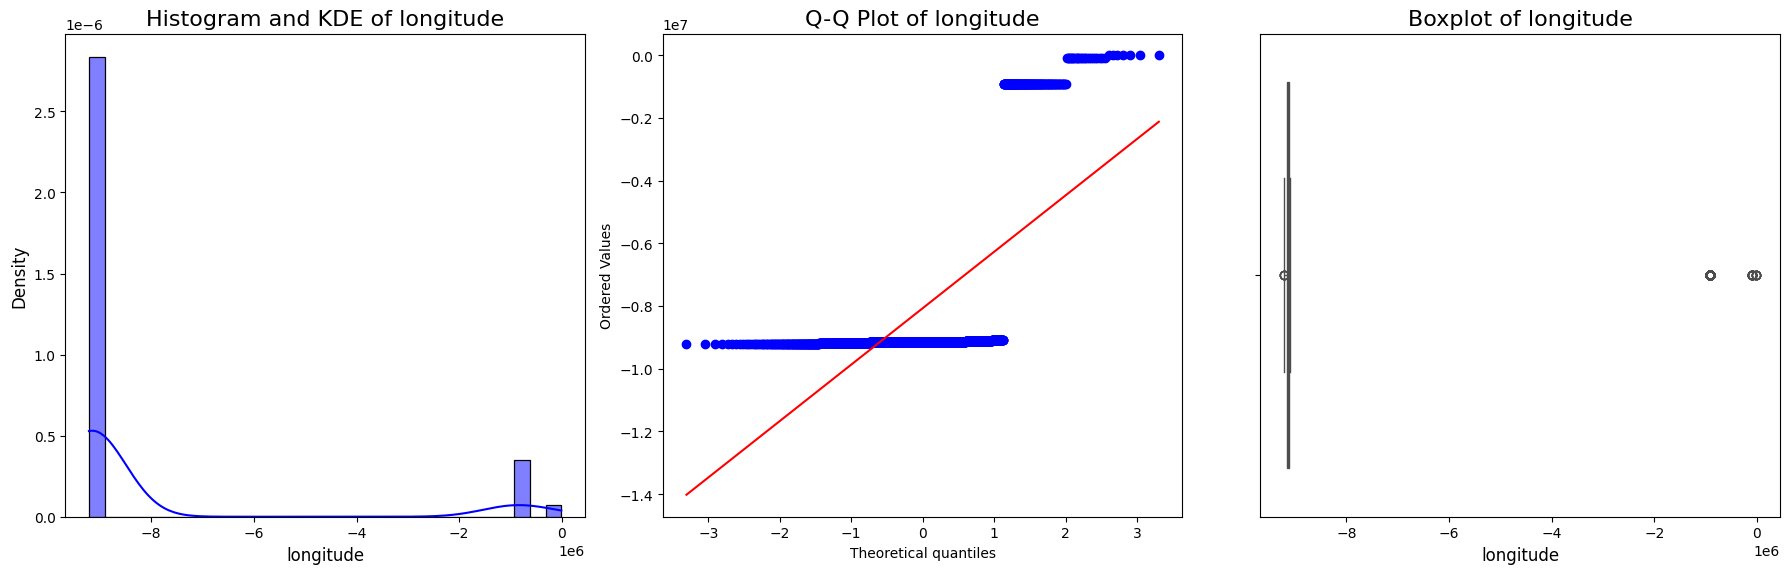

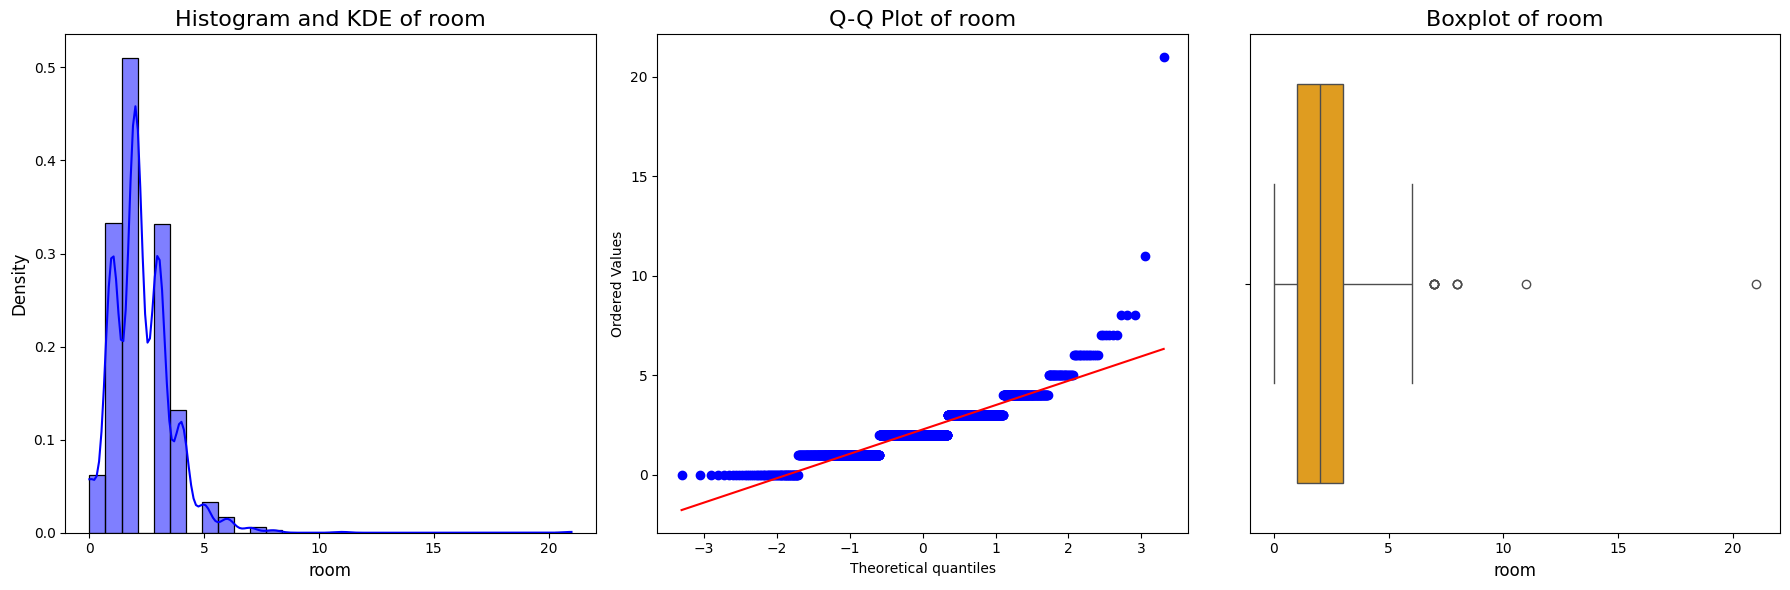

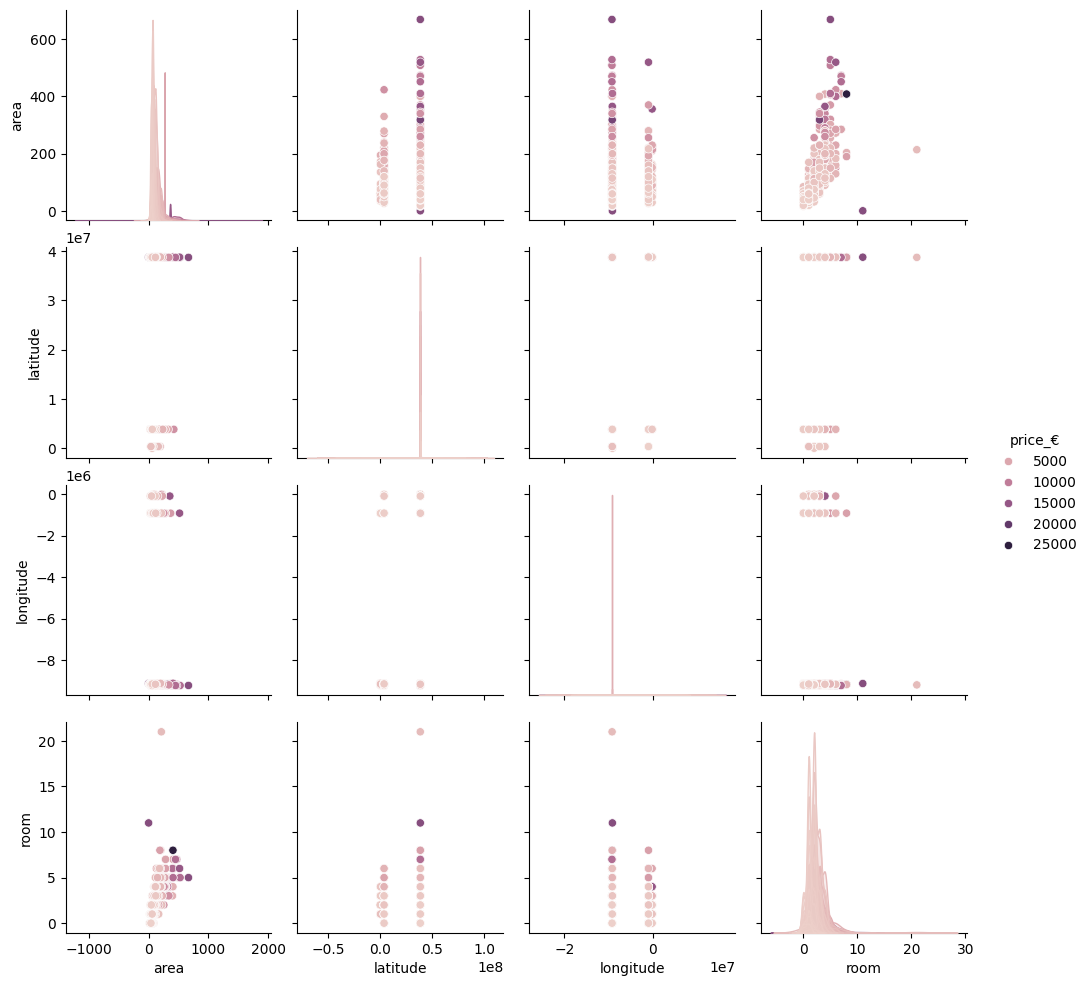

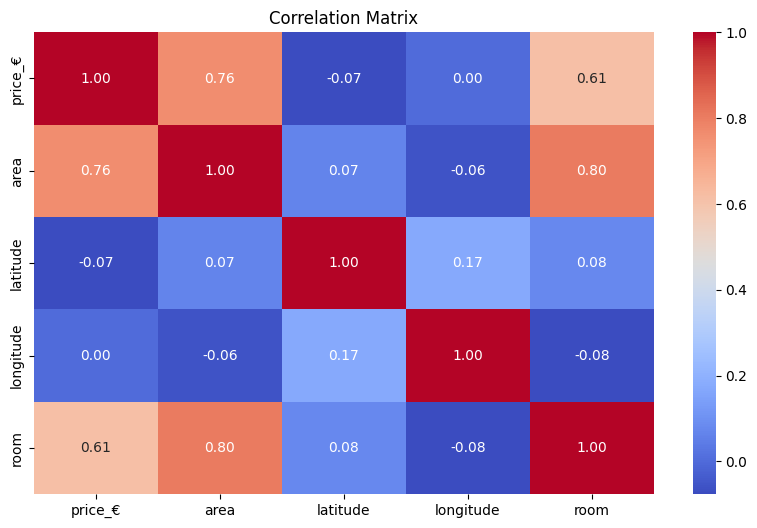

Z-score method removed 62 rows, which is less than the IQR method (103 rows).


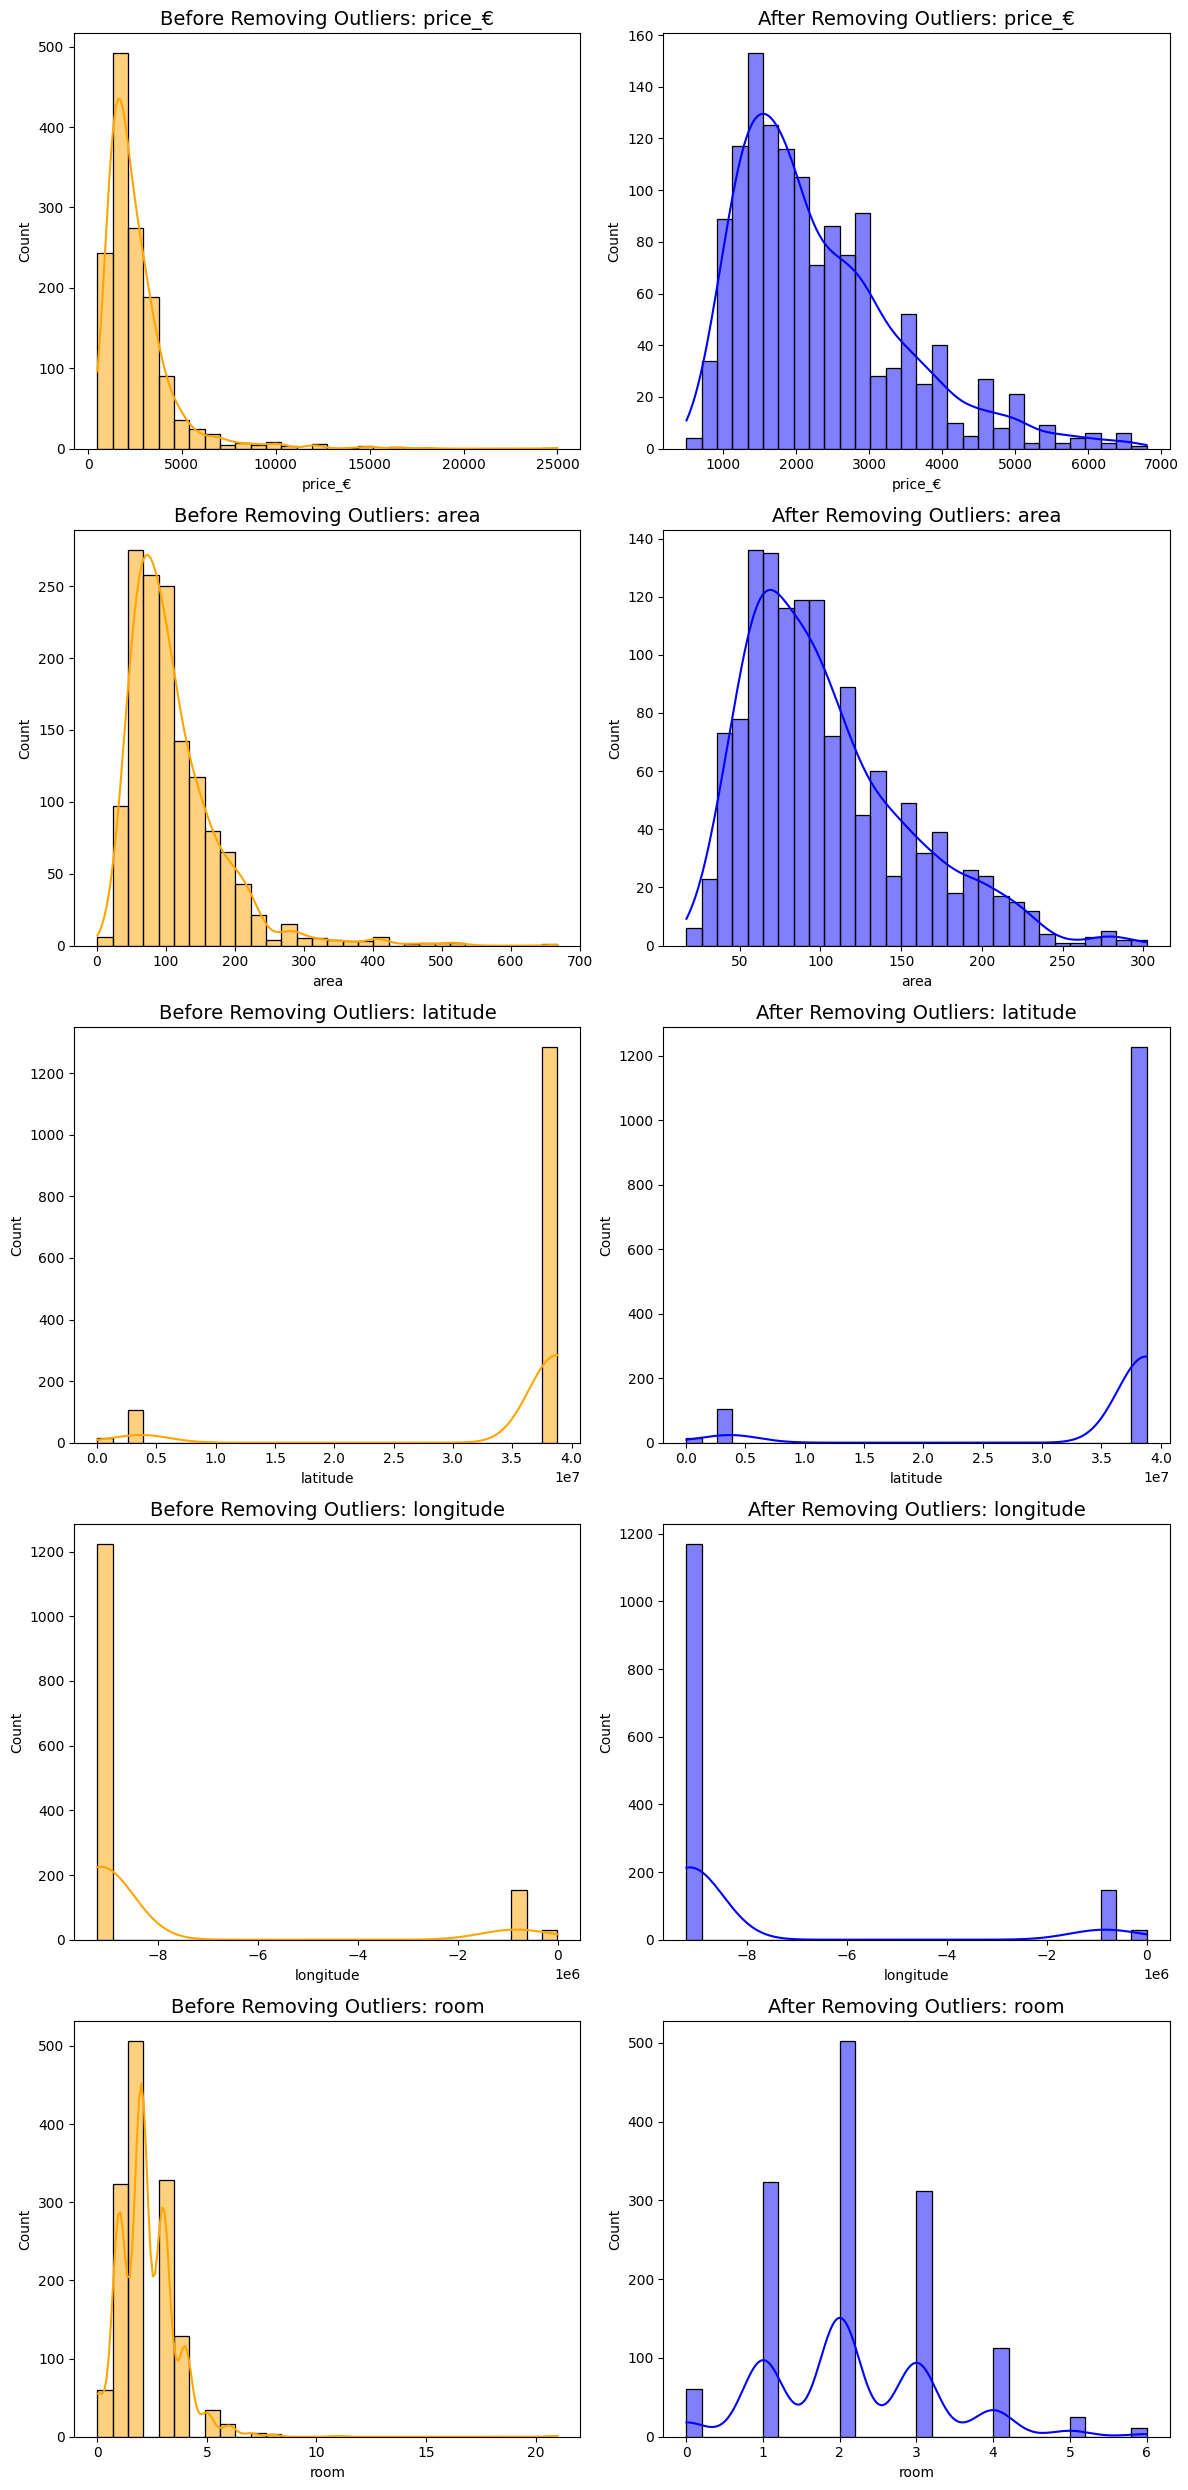


Modeling with Decision Tree:
Decision Tree Metrics:
MSE: 702173.3229895568, MAE: 649.7136778914864, R2 Score: 0.3654002934979329
Decision Tree - R2 Score: 0.3654002934979329

Modeling with Linear Regression:
Linear Regression Metrics:
MSE: 615057.2714858081, MAE: 615.4165202482209, R2 Score: 0.4441327359104741
Linear Regression - R2 Score: 0.4441327359104741


In [26]:
ds_path:str = "../data/learning/rental_in_lisbon/rental_lisbon.csv"
data_frame :pd.DataFrame = load_data_and_inspect(ds_path)


summary(data_frame)

# EDA
generate_distribution_plots(df=data_frame, plot_fn=plot_distribution,exclude_columns=['address'])
generate_distribution_plots(df=data_frame, plot_fn=plot_distribution,distribution_type=DistributionType.NUMERICAL,exclude_columns=['latitude', 'longitude'])

normality_test_with_plots(data_frame)

plot_correlation_test(data_frame, 'price_€')


data_frame_prepared = data_preparation(data_frame, ['longitude','latitude'])
plot_histogram_before_after(data_frame, data_frame_prepared)

# data_frame_prepared['typology_copy'] = data_frame_prepared['typology']
# data_frame_prepared['neighborhood_copy'] = data_frame_prepared['neighborhood']

# data_frame_prepared = pd.get_dummies(data_frame_prepared, columns=['typology'])

data_train_subset = data_frame_prepared.copy()
data_train_subset.drop(columns=['address','typology', 'neighborhood','longitude','latitude','room'],inplace=True)


train_definition_data, scaler = train_definition(data_train_subset,'price_€')

modeling_decision_tree(train_definition_data)
# dt_regressor = sleep_hyperparameter_tuning(sleep_train_definition_data)

l_regressor = modeling_linear_regression(train_definition_data)

# Main

In [23]:
# Example input data for prediction
input_data = {
    "WorkoutTime": 1.5,
    "ReadingTime": 0.5,
    "PhoneTime": 3.0,
    "WorkHours": 8.0,
    "CaffeineIntake": 2,
    "RelaxationTime": 1.0
}

# Convert the input data to a DataFrame
input_df = pd.DataFrame([input_data])

# Apply feature scaling (use the same scaler used for training)
input_scaled = scaler.transform(input_df)

# Predict SleepTime using Decision Tree
predicted_sleep_time_dt = dt_regressor.predict(input_scaled)
print(f"Decision Tree Prediction: {predicted_sleep_time_dt[0]:.2f} hours")

# Predict SleepTime using Linear Regression
predicted_sleep_time_lr = l_regressor.predict(input_scaled)
print(f"Linear Regression Prediction: {predicted_sleep_time_lr[0]:.2f} hours")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CaffeineIntake
- PhoneTime
- ReadingTime
- RelaxationTime
- WorkHours
- ...
Feature names seen at fit time, yet now missing:
- area
- room
- typology_T0
- typology_T1
- typology_T2
- ...
